<a href="https://colab.research.google.com/github/0731325603/regression-predict-api-template/blob/master/regression_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPLORE Data Science Academy Regression Sprint**




### **Sendy Logistics Challenge**:

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, use the historic data to predict an accurate time for the arrival of the rider at the destination of a package. In this competition, we’re challenging you to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

## **Problem Statement**:

*  Build a model to predict the estimated time of delivery of orders, from the 
point of driver pickup to the point of arrival at final destination and build a web based API for the model.



## **Installations**:

In [222]:
#installing catboost 
!pip install catboost

## **Imports**:

In [0]:
# import libraries
from google.colab import files
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

## **Data Loading**:

**Data files:**

*  Train.csv - is the dataset that you will use to train your model.
*  Test.csv - is the dataset on which you will apply your model to.
*  Riders.csv - contains unique rider Ids, number of orders, age, rating and number of ratings

**Variables**

1.  **Order details**
>*  Order No – Unique number identifying the order
>*  User Id – Unique number identifying the customer on a platform
>*  Vehicle Type – For this competition limited to bikes, however in practice, Sendy service extends to trucks and vans
>*  Platform Type – Platform used to place the order, there are 4 types
>*  Personal or Business – Customer type

2.  **Placement times**
>*  Placement - Day of Month i.e 1-31
>*  Placement - Weekday (Monday = 1)
>*  Placement - Time - Time of day the order was placed

3.  **Confirmation times**
>*  Confirmation - Day of Month i.e 1-31
>*  Confirmation - Weekday (Monday = 1)
>*  Confirmation - Time - time of day the order was confirmed by a rider

4.  **Arrival at Pickup times**
>*  Arrival at Pickup - Day of Month i.e 1-31
>*  Arrival at Pickup - Weekday (Monday = 1)
>*  Arrival at Pickup - Time - Time of day the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application

5.  **Pickup times**
>*  Pickup - Day of Month i.e 1-31
>*  Pickup - Weekday (Monday = 1)
>*  Pickup - Time - Time of day the rider picked up the order - as marked by the rider through the Sendy application

6.  **Arrival at Destination times** (column missing in Test set)
>*  Arrival at Delivery - Day of Month i.e 1-31
>*  Arrival at Delivery - Weekday (Monday = 1)
>*  Arrival at Delivery - Time - Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application
>*  Distance covered (KM) - The distance from Pickup to Destination
>*  Temperature -Temperature at the time of order placement in Degrees Celsius (measured every three hours)
>*  Precipitation in Millimeters - Precipitation at the time of order placement (measured every three hours)
>*  Pickup Latitude and Longitude - Latitude and longitude of pick up location
>*  Destination Latitude and Longitude - Latitude and longitude of delivery location
>*  Rider ID – ID of the Rider who accepted the order
>*  Time from Pickup to Arrival - Time in seconds between ‘Pickup’ and ‘Arrival at Destination’ - calculated from the columns for the purpose of facilitating the task

7.  **Rider metrics**
>*  Rider ID – Unique number identifying the rider (same as in order details)
>*  No of Orders – Number of Orders the rider has delivered
>*  Age – Number of days since the rider delivered the first order
>*  Average Rating – Average rating of the rider
>*  No of Ratings - Number of ratings the rider has received. Rating an order is optional for the customer.

In [0]:
# load data from csv files 
train_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Test.csv')
rider_data = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/Riders.csv')
samplesubmission = pd.read_csv('https://raw.githubusercontent.com/0731325603/regression-predict-api-template/master/Data/SampleSubmission.csv')


In [225]:
# view train data
train_data.head()


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [226]:
# view test data
test_data.head()


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [227]:
# view riders data
rider_data.head()


,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


## **Functions**:

In [0]:
# investigate unique values in a given column
def total_unique_values(df, column_name):
  """Select column with missing values in a dataframe and return that."""
  return len(np.unique(df[column_name]))
    
# investigate missing columns between 2 dataframes
def total_missing_columns(df1, df2):
  """
  Select dataframe one and dataframe two and return a new dataframe
  containing the difference between df1 and df2.
  """
  return [col for col in df1.columns if col in df1.columns and col not in df2.columns]

# slit string time into Hours, Min, Sec and return dataframe containing such
def split_str_time(df, column_name):
  """
  Separate time and return new dataframe with time separated in hours,
  minutes and seconds with a description of AM or PM.
  """
  h = []
  m = []
  s = []
  x = []
  for time in df[column_name]:
    time_str1 = time.split(" ")
    time_str2 = time_str1[0].split(":")
    h.append(int(time_str2[0]))
    m.append(int(time_str2[1]))
    s.append(int(time_str2[2]))
    x.append(time_str1[1])

  my_dict = {'Hour':h, 'Min':m, 'Sec':s, 'AM_PM':x}
  new_df = pd.DataFrame(my_dict)
  new_df[column_name] = df[column_name]
  return new_df


## **Data Preprocessing**:

### **Exploratory Data Analysis**:

### **Explore relationships**

*   Find relationships between tables.



In [229]:
# print the shapes of the dastaframes
print("Train data: {}".format(train_data.shape))
print("Test data: {}".format(test_data.shape))
print("Rider data: {}".format(rider_data.shape))


Train data: (21201, 29)
Test data: (7068, 25)
Rider data: (960, 5)


In [230]:
# print the column names of the dastaframes
print("Train data:\n{}".format(train_data.columns))
print("\nTest data:\n{}".format(test_data.columns))
print("\nRider data:\n{}".format(rider_data.columns))


Train data:
Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

Test data:
Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - We

In [231]:
# investigate missing columns
total_missing_columns(train_data, test_data)


['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival']

In [0]:
# save number of rows
train = train_data.shape[0]
test = test_data.shape[0]


In [233]:
# combine test and train data
combined_data = pd.concat((train_data, test_data)).reset_index(drop=True)

# view shape
combined_data.shape

(28269, 29)

In [234]:
# join combined data with the riders data
combined_data = pd.merge(combined_data, rider_data, how='left', on=['Rider Id'])

# view shape
combined_data.shape


(28269, 33)

In [0]:
# drop missing columns
combined_data = combined_data.drop(['Arrival at Destination - Day of Month', 
                                    'Arrival at Destination - Weekday (Mo = 1)', 
                                    'Arrival at Destination - Time'], axis=1)


In [236]:
# checking features and target columns
combined_data.columns


Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Time from Pickup to Arrival', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings'],
      dtype='object')

In [237]:
# check combined data info
combined_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 28268
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              28269 non-null  object 
 1   User Id                               28269 non-null  object 
 2   Vehicle Type                          28269 non-null  object 
 3   Platform Type                         28269 non-null  int64  
 4   Personal or Business                  28269 non-null  object 
 5   Placement - Day of Month              28269 non-null  int64  
 6   Placement - Weekday (Mo = 1)          28269 non-null  int64  
 7   Placement - Time                      28269 non-null  object 
 8   Confirmation - Day of Month           28269 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)       28269 non-null  int64  
 10  Confirmation - Time                   28269 non-null  object 
 11  Arrival at Pick

**Notes and Insights**:

*   All dataframes have 'Rider Id' column, join rider_data to both train and test dataframes.
*   Train and Test data differs by 4 columns.



### **Missing Values**:

In [238]:
# count number of null values per column
combined_data.isnull().sum()


Order No                                    0
User Id                                     0
Vehicle Type                                0
Platform Type                               0
Personal or Business                        0
Placement - Day of Month                    0
Placement - Weekday (Mo = 1)                0
Placement - Time                            0
Confirmation - Day of Month                 0
Confirmation - Weekday (Mo = 1)             0
Confirmation - Time                         0
Arrival at Pickup - Day of Month            0
Arrival at Pickup - Weekday (Mo = 1)        0
Arrival at Pickup - Time                    0
Pickup - Day of Month                       0
Pickup - Weekday (Mo = 1)                   0
Pickup - Time                               0
Distance (KM)                               0
Temperature                              5803
Precipitation in millimeters            27518
Pickup Lat                                  0
Pickup Long                       

In [239]:
# investigate unique values in each columns
for col in combined_data.columns:
  print('The number of unique values in {} :{}'.format(col, 
                                      total_unique_values(combined_data, col)))


The number of unique values in Order No :28269
The number of unique values in User Id :3782
The number of unique values in Vehicle Type :1
The number of unique values in Platform Type :4
The number of unique values in Personal or Business :2
The number of unique values in Placement - Day of Month :31
The number of unique values in Placement - Weekday (Mo = 1) :7
The number of unique values in Placement - Time :19062
The number of unique values in Confirmation - Day of Month :31
The number of unique values in Confirmation - Weekday (Mo = 1) :7
The number of unique values in Confirmation - Time :19180
The number of unique values in Arrival at Pickup - Day of Month :31
The number of unique values in Arrival at Pickup - Weekday (Mo = 1) :7
The number of unique values in Arrival at Pickup - Time :19189
The number of unique values in Pickup - Day of Month :31
The number of unique values in Pickup - Weekday (Mo = 1) :7
The number of unique values in Pickup - Time :19161
The number of unique v

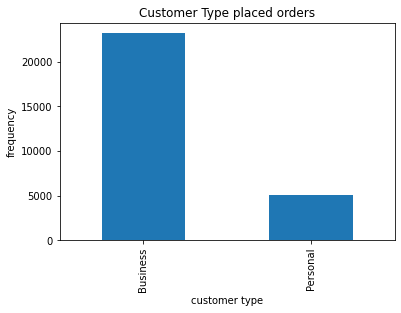

In [240]:
# bar graph to view dominating customer type
y_count=combined_data['Personal or Business'].value_counts(sort=True)
y_count.plot(kind='bar')
plt.xlabel("customer type")
plt.ylabel("frequency")

# add title 
plt.title('Customer Type placed orders')

# show bar graph
plt.show()


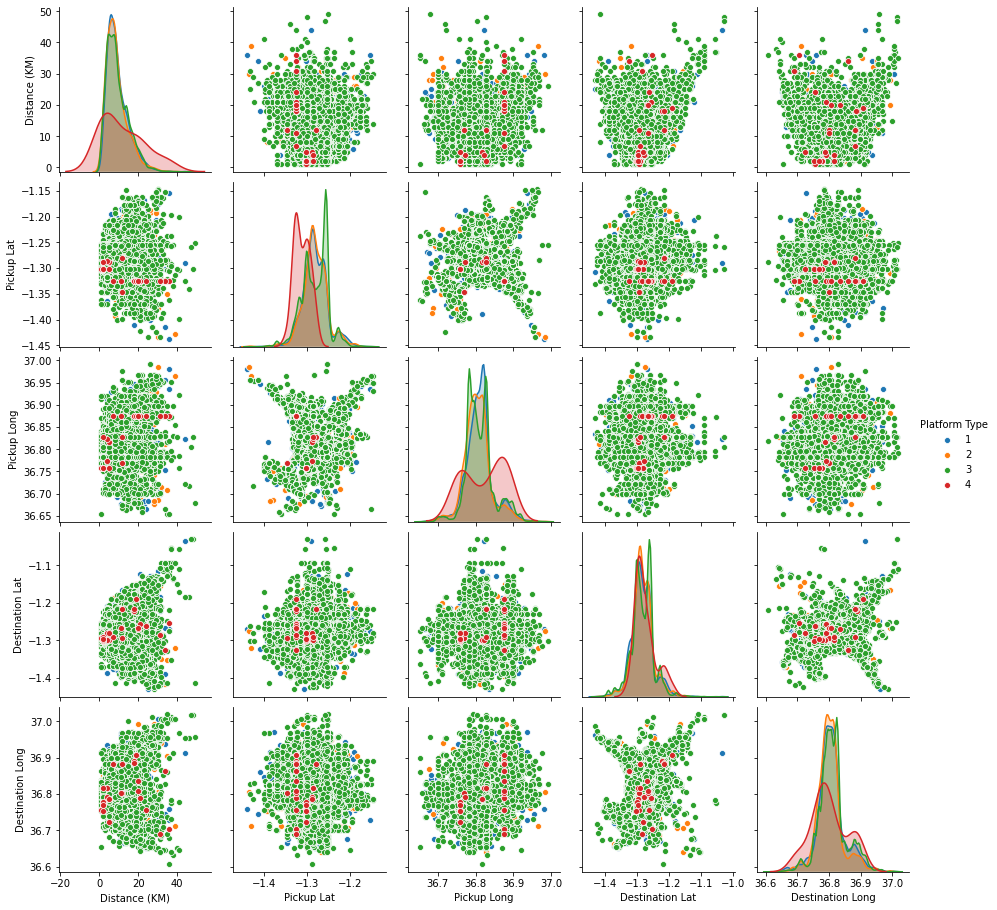

In [241]:
# visualising a subset of the data
g = sns.pairplot(combined_data[['Distance (KM)', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Platform Type']],hue='Platform Type')


Text(0.5, 1.0, 'Distribution for day of the week in relation to Time From Pickup to Arrival')

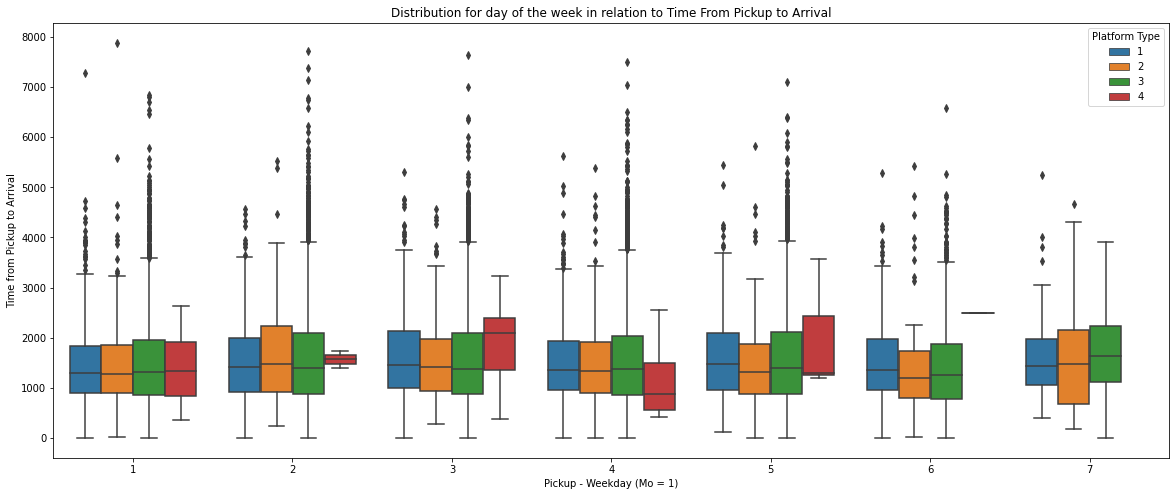

In [242]:
# investigate the distribution by categorical variables
plt.figure(figsize=(20, 8))
g = sns.boxplot(x='Pickup - Weekday (Mo = 1)', y='Time from Pickup to Arrival', 
                data=combined_data, hue='Platform Type')

# add title
plt.title('Distribution for day of the week in relation to Time From Pickup to Arrival')


**Notes and Insights**:


*   Platform 4 is available from Monday to Friday, on weekends it's not actively used.During weekdays when compared to the other platforms tend to find that it avarage almost match with other platform except on Thursday.
*   Platform 3 is the most dominating platform with outliers.

In [0]:
# drop Precipitation in millimeters
combined_data = combined_data.drop(['Precipitation in millimeters'], axis=1)


In [244]:
# get summary stats for Temperature
combined_data['Temperature'].describe()


count    22466.000000
mean        23.255689
std          3.609541
min         11.200000
25%         20.600000
50%         23.400000
75%         26.000000
max         32.100000
Name: Temperature, dtype: float64

Text(0.5, 1.0, 'Temperature Summary Statistics')

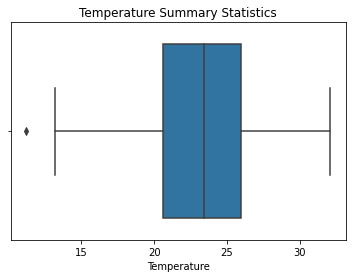

In [245]:
# boxplot to view the distribution
ag = sns.boxplot(combined_data['Temperature'])

# add title
plt.title("Temperature Summary Statistics")


In [0]:
# replace null values in the Temperature column with the mean
combined_data['Temperature'] = combined_data['Temperature'].fillna(
    (combined_data['Temperature'].mean()))


In [247]:
# count number of null values
combined_data.isnull().sum()


Order No                                   0
User Id                                    0
Vehicle Type                               0
Platform Type                              0
Personal or Business                       0
Placement - Day of Month                   0
Placement - Weekday (Mo = 1)               0
Placement - Time                           0
Confirmation - Day of Month                0
Confirmation - Weekday (Mo = 1)            0
Confirmation - Time                        0
Arrival at Pickup - Day of Month           0
Arrival at Pickup - Weekday (Mo = 1)       0
Arrival at Pickup - Time                   0
Pickup - Day of Month                      0
Pickup - Weekday (Mo = 1)                  0
Pickup - Time                              0
Distance (KM)                              0
Temperature                                0
Pickup Lat                                 0
Pickup Long                                0
Destination Lat                            0
Destinatio

## **Data Cleaning**:

In [0]:
# extract AM/PM form pickup time
combined_data['AM_or_PM'] = combined_data['Pickup - Time'].astype('str').apply(
    lambda x:x.split(' ')[-1])


In [249]:
# view combined data
combined_data.head()


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,AM_or_PM
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,1637,1309,13.8,549,AM
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,396,339,13.6,69,AM
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,3,23.255689,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,1023,242,12.5,114,PM
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0,886,283,14.5,113,AM
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0,2311,872,14.1,533,AM


In [0]:
# select useful column
combined_data.drop(['Order No','Arrival at Pickup - Time','Confirmation - Time',
                    'Pickup - Time','Placement - Time','Rider Id']
                   ,axis=1, inplace=True)


In [0]:
# set replacement values
transport = {"Vehicle Type":     {"Bike": 1, "Other": 2},
                "Personal or Business": {"Personal": 1, "Business": 2,}}


In [0]:
# replace values
combined_data.replace(transport, inplace=True)


In [0]:
# convert to dummys
combined_data = pd.get_dummies(combined_data)


In [254]:
# get the new dataset
train_new = combined_data[:train]
test_new = combined_data[train:]

# print shape
print(train_new.shape)
print(test_new.shape)


(21201, 3806)
(7068, 3806)


In [0]:
# drop target column from test data new
test_new = test_new.drop(['Time from Pickup to Arrival'], axis=1)


## **Feature Selection**: 

In [256]:
# view new train data
train_new.head()


,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,User Id_User_Id_0,User Id_User_Id_1,User Id_User_Id_10,User Id_User_Id_100,User Id_User_Id_1000,User Id_User_Id_1001,User Id_User_Id_1002,User Id_User_Id_1003,User Id_User_Id_1004,User Id_User_Id_1005,User Id_User_Id_1006,User Id_User_Id_1007,User Id_User_Id_1008,User Id_User_Id_1009,User Id_User_Id_101,User Id_User_Id_1010,User Id_User_Id_1011,User Id_User_Id_1012,...,User Id_User_Id_965,User Id_User_Id_966,User Id_User_Id_967,User Id_User_Id_968,User Id_User_Id_969,User Id_User_Id_97,User Id_User_Id_970,User Id_User_Id_971,User Id_User_Id_972,User Id_User_Id_973,User Id_User_Id_974,User Id_User_Id_975,User Id_User_Id_976,User Id_User_Id_977,User Id_User_Id_978,User Id_User_Id_979,User Id_User_Id_98,User Id_User_Id_980,User Id_User_Id_981,User Id_User_Id_982,User Id_User_Id_983,User Id_User_Id_984,User Id_User_Id_985,User Id_User_Id_986,User Id_User_Id_987,User Id_User_Id_988,User Id_User_Id_989,User Id_User_Id_99,User Id_User_Id_990,User Id_User_Id_991,User Id_User_Id_992,User Id_User_Id_993,User Id_User_Id_994,User Id_User_Id_995,User Id_User_Id_996,User Id_User_Id_997,User Id_User_Id_998,User Id_User_Id_999,AM_or_PM_AM,AM_or_PM_PM
0,1,3,2,9,5,9,5,9,5,9,5,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,745.0,1637,1309,13.8,549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,3,1,12,5,12,5,12,5,12,5,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,1993.0,396,339,13.6,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,3,2,30,2,30,2,30,2,30,2,3,23.255689,-1.308284,36.843419,-1.300921,36.828195,455.0,1023,242,12.5,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,3,2,15,5,15,5,15,5,15,5,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,1341.0,886,283,14.5,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,1,1,13,1,13,1,13,1,13,1,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,1214.0,2311,872,14.1,533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
# run correlation of select columns
cols = train_new[['Pickup - Day of Month',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Time from Pickup to Arrival',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']].corr()
      

Text(0.5, 1.0, 'Data correlation for Selected Features')

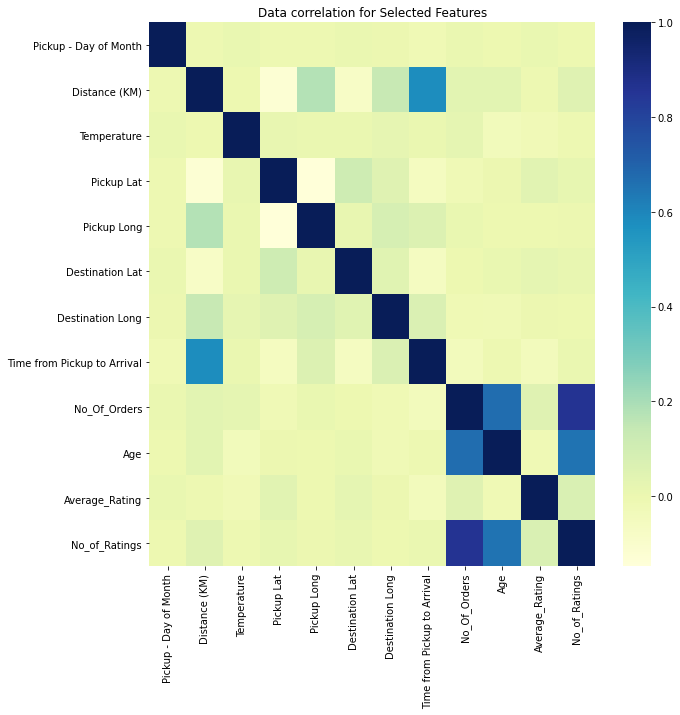

In [258]:
# visualize correlation with a Heatmap
plt.figure(figsize = (10, 10))
g = sns.heatmap(cols, cmap="YlGnBu")

# add title
plt.title("Data correlation for Selected Features")


In [259]:
# split the data into X & y
X = train_new.drop(columns='Time from Pickup to Arrival')
y = train_new['Time from Pickup to Arrival']

# print the shape
print("X: {}".format(X.shape))
print("y: {}".format(y.shape))


X: (21201, 3805)
y: (21201,)


## **Splitting the Raw Data**:



The data is split 3 ways
*   **Train**:
> 1. X_train
> 2. y_train
*   **Validation**:
> 1. X_validation
> 2. y_validation
*   **Test**:
> 1. X_test
> 2. y_test


In [260]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# print the shape
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(13568, 3805)
(4241, 3805)
(3392, 3805)
(13568,)
(4241,)
(3392,)


## **Model Selection**:

### **Linear Regression Model**:

In [261]:
# create model object and fit X_train
lr = LinearRegression()
lr.fit(X_train, y_train)

# results on test
y_pred_t = lr.predict(X_train)
y_pred_v = lr.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


Train RMSE:  716.7194202605315
Test RMSE:  23715201035.151447


### **Random Forest Model**:

In [262]:
# create model object and fit X_train
regr = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)
regr.fit(X_train, y_train)

# results on test
y_pred_t = regr.predict(X_train)
y_pred_v = regr.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


Train RMSE:  772.7272417737979
Test RMSE:  788.4655112790398


### **XGBoost Regression Model**:

In [263]:
# create model object and fit X_train
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_train)

# results on test
y_pred_t = xg_reg.predict(X_train)
y_pred_v = xg_reg.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


[20:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE:  753.3729212400926
Test RMSE:  773.7496962261845


### **CatBoost Regression Model**:

In [264]:
# create model object and fit X_train
regressor = CatBoostRegressor(iterations=600,
                              learning_rate=0.1,
                              depth=4,
                              l2_leaf_reg=10,
                              bootstrap_type='Bernoulli',
                              subsample=0.7,
                              leaf_estimation_iterations=10,
                              metric_period=20,
                              od_type='Iter',
                              od_wait=45,
                              random_seed=42,
                              loss_function='RMSE',
                              allow_writing_files=False)
regressor.fit(X_train, y_train)

# results on test
y_pred_t = regressor.predict(X_train)
y_pred_v = regressor.predict(X_validation)

# print RMSE score
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_t)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_validation, y_pred_v)))


0:	learn: 959.0804791	total: 9.82ms	remaining: 5.88s
20:	learn: 797.6579790	total: 197ms	remaining: 5.42s
40:	learn: 778.2098198	total: 382ms	remaining: 5.21s
60:	learn: 770.5602858	total: 563ms	remaining: 4.97s
80:	learn: 764.9479794	total: 748ms	remaining: 4.79s
100:	learn: 759.2575534	total: 930ms	remaining: 4.59s
120:	learn: 753.2543633	total: 1.12s	remaining: 4.42s
140:	learn: 748.3274289	total: 1.3s	remaining: 4.25s
160:	learn: 743.0678423	total: 1.49s	remaining: 4.06s
180:	learn: 738.8238556	total: 1.68s	remaining: 3.88s
200:	learn: 735.3915267	total: 1.86s	remaining: 3.7s
220:	learn: 730.9298111	total: 2.04s	remaining: 3.5s
240:	learn: 726.6194571	total: 2.24s	remaining: 3.34s
260:	learn: 723.1316490	total: 2.42s	remaining: 3.14s
280:	learn: 720.4232957	total: 2.61s	remaining: 2.96s
300:	learn: 717.3650872	total: 2.79s	remaining: 2.77s
320:	learn: 714.7481744	total: 2.98s	remaining: 2.59s
340:	learn: 711.6993923	total: 3.16s	remaining: 2.4s
360:	learn: 708.9348722	total: 3.36s	

## **Feature Importance**:

In [265]:
# find categorical features
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# veiw features
categorical_features_indices


array([   0,    1,    2, ..., 3802, 3803, 3804])

In [266]:
# fit selected model
regressor.fit(X_train, y_train,cat_features=categorical_features_indices,
              eval_set=(X, y),plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 959.1764064	test: 957.3918645	best: 957.3918645 (0)	total: 31.7ms	remaining: 19s
20:	learn: 804.2662617	test: 799.2036549	best: 799.2036549 (20)	total: 586ms	remaining: 16.1s
40:	learn: 788.1226698	test: 781.9153979	best: 781.9153667 (39)	total: 1.31s	remaining: 17.9s
60:	learn: 779.0467406	test: 772.4458531	best: 772.4458531 (60)	total: 1.98s	remaining: 17.5s
80:	learn: 772.5460063	test: 766.7085002	best: 766.7085002 (80)	total: 2.76s	remaining: 17.7s
100:	learn: 768.2444533	test: 763.3027889	best: 763.3027889 (100)	total: 3.52s	remaining: 17.4s
120:	learn: 761.6058572	test: 758.1054933	best: 758.1054933 (120)	total: 4.38s	remaining: 17.3s
140:	learn: 756.5226868	test: 753.7953518	best: 753.7953518 (140)	total: 5.19s	remaining: 16.9s
160:	learn: 751.6473619	test: 750.0938446	best: 750.0938446 (160)	total: 6.02s	remaining: 16.4s
180:	learn: 747.4828198	test: 746.9092287	best: 746.9092287 (180)	total: 6.86s	remaining: 15.9s
200:	learn: 744.9631333	test: 745.4443809	best: 745.4

In [267]:
# check feature importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(
    regressor.feature_importances_,2)})
importances = importances.sort_values('importance',
                                      ascending=False).set_index('feature')

# view feature importance 
importances.head(15)


,importance
feature,
Distance (KM),39.66
Destination Lat,7.98
Pickup Lat,5.64
Average_Rating,5.60
No_of_Ratings,5.06
No_Of_Orders,3.72
Pickup Long,3.42
Destination Long,3.13
Platform Type,2.77


In [268]:
# fit entire training data
regressor.fit(train_new.drop(['Time from Pickup to Arrival'], axis =1), 
              train_new['Time from Pickup to Arrival'])


0:	learn: 959.3153964	total: 11.4ms	remaining: 6.8s
20:	learn: 794.8522701	total: 236ms	remaining: 6.5s
40:	learn: 779.2564614	total: 458ms	remaining: 6.25s
60:	learn: 771.2674542	total: 708ms	remaining: 6.25s
80:	learn: 765.6089901	total: 939ms	remaining: 6.01s
100:	learn: 759.4504744	total: 1.17s	remaining: 5.79s
120:	learn: 754.5088106	total: 1.41s	remaining: 5.56s
140:	learn: 750.9363532	total: 1.64s	remaining: 5.35s
160:	learn: 747.7511331	total: 1.91s	remaining: 5.22s
180:	learn: 744.7722372	total: 2.15s	remaining: 4.97s
200:	learn: 741.6572716	total: 2.38s	remaining: 4.72s
220:	learn: 738.6369729	total: 2.62s	remaining: 4.49s
240:	learn: 735.9122630	total: 2.86s	remaining: 4.26s
260:	learn: 733.4862586	total: 3.1s	remaining: 4.02s
280:	learn: 731.0594373	total: 3.33s	remaining: 3.78s
300:	learn: 728.4383122	total: 3.56s	remaining: 3.54s
320:	learn: 726.2245234	total: 3.81s	remaining: 3.31s
340:	learn: 724.0003866	total: 4.05s	remaining: 3.08s
360:	learn: 722.1258012	total: 4.28s

### **Learning Curve**:

Text(0.5, 1.0, 'Learning curves fo a catboost model')

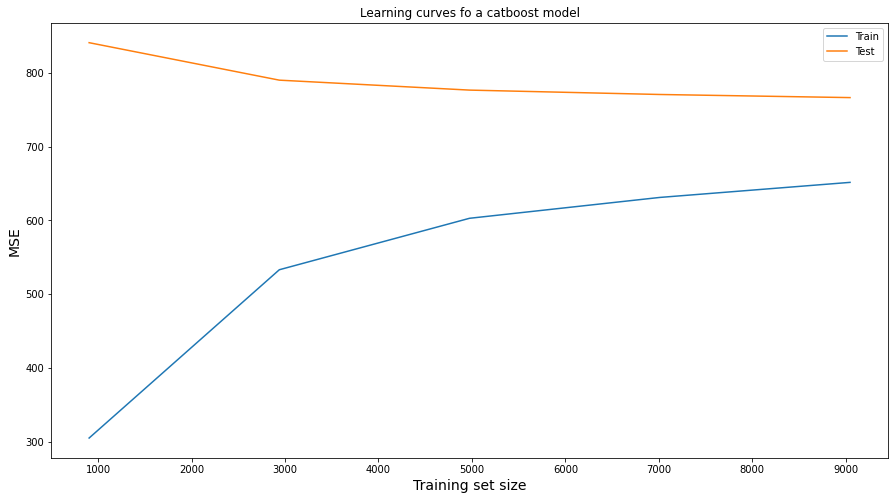

In [269]:
# compute the learning curve
line = learning_curve(regressor, X_train, y_train, cv=3, n_jobs=-1, scoring='neg_mean_squared_error') 
train_score = [-line[1][i].mean() for i in range (0, 5)]
test_score = [-line[2][i].mean() for i in range (0, 5)]

# Plot learning curve
fig = plt.figure(figsize = (15, 8))
plt.plot(line[0], np.sqrt(train_score), label = 'Train')
plt.plot(line[0], np.sqrt(test_score), label = 'Test')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves fo a catboost regression model')


## **Submission**:

In [0]:
#serializes the model prediction before writing it to file
regressor.predict(test_new)
save_path = 'sendy_regression.pkl'
pickle.dump(regressor, open('sendy_regression.pkl','wb'))
files.download('sendy_regression.pkl')


In [272]:
# create a dataframe containing target predicts
pred = pd.DataFrame(regressor.predict(test_new),
                    columns= ['Time from Pickup to Arrival' ])

# join pred to samplesubmission
pred = pd.concat([samplesubmission['Order_No'], pred], axis =1)

# remove decimals
pred  = pred.round() 

# veiw pred
pred.head()


,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1532.0
1,Order_No_12736,1233.0
2,Order_No_768,1373.0
3,Order_No_15332,1209.0
4,Order_No_21373,1197.0


In [0]:
# download csv
pred.to_csv('Submit_11.csv',index=False) 
files.download('Submit_11.csv')
